In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

[0]	validation_0-rmse:1.06599
[1]	validation_0-rmse:1.05669
[2]	validation_0-rmse:1.04809
[3]	validation_0-rmse:1.04012
[4]	validation_0-rmse:1.03277
[5]	validation_0-rmse:1.02597
[6]	validation_0-rmse:1.01971
[7]	validation_0-rmse:1.01392
[8]	validation_0-rmse:1.00858
[9]	validation_0-rmse:1.00366
[10]	validation_0-rmse:0.99912
[11]	validation_0-rmse:0.99495
[12]	validation_0-rmse:0.99109
[13]	validation_0-rmse:0.98754
[14]	validation_0-rmse:0.98428
[15]	validation_0-rmse:0.98127
[16]	validation_0-rmse:0.97849
[17]	validation_0-rmse:0.97594
[18]	validation_0-rmse:0.97356
[19]	validation_0-rmse:0.97142
[20]	validation_0-rmse:0.96943
[21]	validation_0-rmse:0.96761
[22]	validation_0-rmse:0.96594
[23]	validation_0-rmse:0.96440
[24]	validation_0-rmse:0.96297
[25]	validation_0-rmse:0.96168
[26]	validation_0-rmse:0.96049
[27]	validation_0-rmse:0.95938
[28]	validation_0-rmse:0.95836
[29]	validation_0-rmse:0.95742
[30]	validation_0-rmse:0.95656
[31]	validation_0-rmse:0.95579
[32]	validation_0-

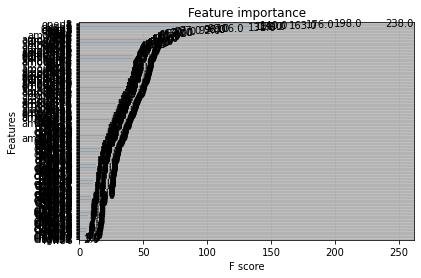

low4      0.008046
high4     0.007713
close4    0.005885
i1        0.004796
low18     0.004739
            ...   
open47    0.001581
open10    0.001551
open2     0.001501
open40    0.001352
open1     0.001147
Length: 366, dtype: float32 

Linear Model Coef:
open32      0.088452
close43     0.070769
close32     0.067897
close40     0.067154
amount24    0.063315
              ...   
high31     -0.074898
open35     -0.075588
high55     -0.086554
low43      -0.087099
high32     -0.088531
Length: 366, dtype: float64


In [2]:
import scutquant.scutquant as q
from scutquant import report, executor

model = q.hybrid()
model.fit(X_train, y_train, X_valid, y_valid)
model.explain_model(index=X_train.columns)

In [3]:
import pandas as pd

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

,predict
count,281840.000000
mean,-0.000138
std,0.001267
min,-0.040924
25%,-0.000722
50%,-0.000024
75%,0.000570
max,0.025942


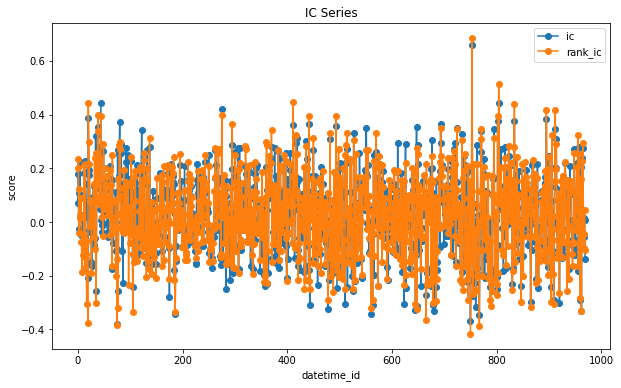

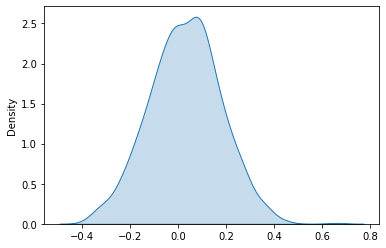

ic= 0.029623436392404178 icir= 0.19977179563782463 rank_ic= 0.02802270701484635 rank_icir= 0.18221413228141856


0.024890786620701252

In [4]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


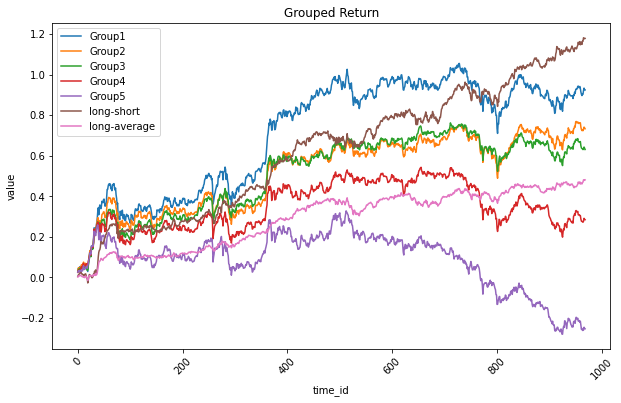

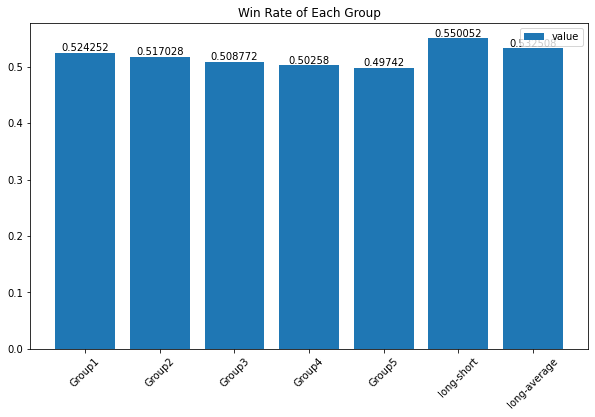

In [5]:
# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [6]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%的股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.10588196270898576
Annualized Volatility: 0.4598329527938356
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3389941216655789 

Cumulative Rate of Return: 0.4725520183888743
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.13296645535332563 

Max Drawdown: -0.2928867093138543
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 1.3579620205263938
Sortino Ratio: -0.4795871192395834
Information Ratio: -0.4095455484120001 

Beta: 1.0753588600830233
Alpha: -0.12727803205044325
Epsilon: 0.1429321648805971
Profitable Days(%): 0.3281733746130031


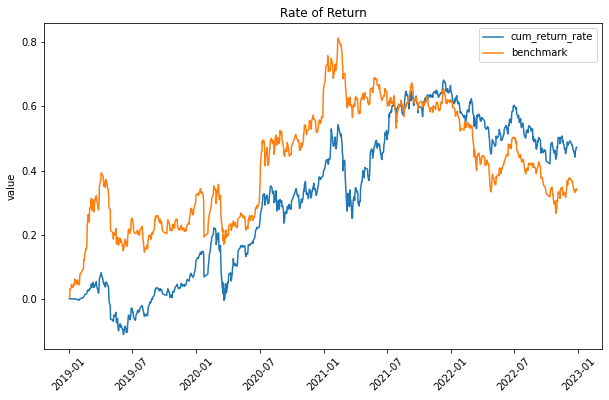

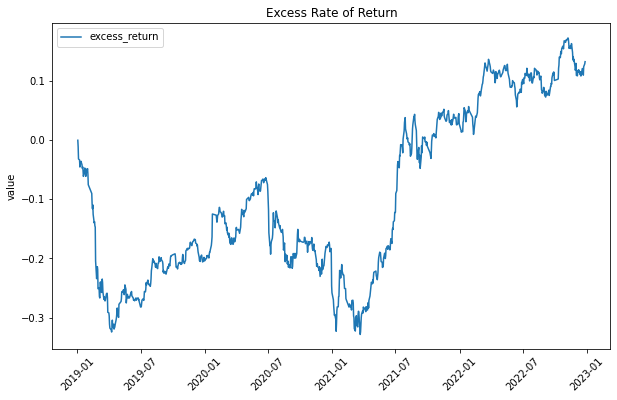

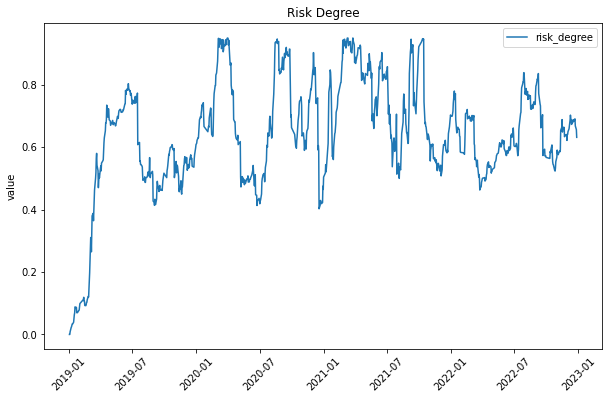

In [7]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [8]:
model.save("./hybrid")